In [1]:
#!pip install validators
#!pip install torch torchvision torchaudio
#!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
#%pip install torchinfo

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import Dataset

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd
import gc
import traceback

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [4]:
DATADIR = "BeeMachine_quarter"
CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

Import Data

In [5]:
def load_dataset(is_simple_transform=True):
    if is_simple_transform:
        transformer = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])
    else:
        transformer = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4904, 0.4515, 0.3639],
                                    std=[0.2403, 0.2280, 0.2248])
        ])
    
    #Load image
    dataset = datasets.ImageFolder(root=f'{DATADIR}', transform=transformer)
    return dataset


In [6]:
def find_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)
    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    # Final step
    mean /= nimages
    std /= nimages

    print(mean)
    print(std)

#find_mean_std(bee_dataset)
# mean tensor([0.4904, 0.4515, 0.3639])
# std tensor([0.2403, 0.2280, 0.2248])


Separate data to train and validation dataset

In [22]:
bee_dataset = load_dataset(is_simple_transform=False)

num_classes=len(bee_dataset.targets)
train_indices, val_indices = train_test_split(list(range(num_classes)), test_size=0.2, stratify=bee_dataset.targets)
train_dataset = torch.utils.data.Subset(bee_dataset, train_indices)
val_dataset = torch.utils.data.Subset(bee_dataset, val_indices)
resnet50.fc = nn.Sequential(
               nn.Linear(2048, 224),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(224, 45),
               nn.Softmax()).to(device) 
torch.autograd.set_detect_anomaly(True)               

Create DataLoader

In [27]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
print(torch.cuda.memory_allocated(device))
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
print(torch.cuda.memory_allocated(device))

216992256
216992256


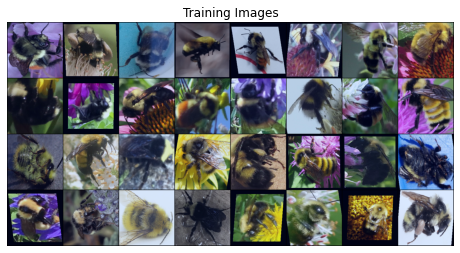

In [10]:
# Plot some training images
real_batch = next(iter(train_data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [20]:
weights = class_weight.compute_class_weight('balanced', np.unique(bee_dataset.targets), bee_dataset.targets)
class_weights=torch.tensor(np.unique(bee_dataset.targets),dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.0001, momentum=0.9)


In [41]:
n_epochs = 1
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataset)

def train_model(model, dataloaders, criterion, optimizer, train_loss, train_acc, total_step, num_epochs=3):
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        model.train()
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(dataloaders):
            data_, target_ = data_.to(device), target_.to(device)            
            outputs = model(data_)
            loss = criterion(outputs, target_)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            #print("matrix predict {} target {}".format(pred, target_))
            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, n_epochs, batch_idx * 32, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        
        validate_model(model_trained, val_data_loader, valid_loss_min, val_loss, val_acc)
                  
    return model



In [38]:
def validate_model(model, dataloaders, valid_loss_min, val_loss, val_acc):
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_, target_ in dataloaders:
            data_t, target_t = data_.to(device), target_.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            #print("predict {} target {}".format(len(pred_t), len(target_t)))
            #print("matrix predict {} target {}".format(pred_t, target_t))
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(dataloaders))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        
        if network_learned:
            modelPath = 'models/pytorch'
            isExist = os.path.exists(modelPath)
            if not isExist:
                # Create a new directory because it does not exist 
                os.makedirs(modelPath)
                print("The new directory {} is created!".format(modelPath))
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'models/pytorch/traiend_resnet50.h5')
            print('Improvement-Detected, save-model')

In [42]:
def show_confusion_matrix(model, labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

Epoch 1

Epoch [1/1], Step [0/31848], Loss: 3.8070
Epoch [1/1], Step [640/31848], Loss: 3.8069
Epoch [1/1], Step [1280/31848], Loss: 3.8062
Epoch [1/1], Step [1920/31848], Loss: 3.8069
Epoch [1/1], Step [2560/31848], Loss: 3.8063
Epoch [1/1], Step [3200/31848], Loss: 3.8067
Epoch [1/1], Step [3840/31848], Loss: 3.8072
Epoch [1/1], Step [4480/31848], Loss: 3.8075
Epoch [1/1], Step [5120/31848], Loss: 3.8072
Epoch [1/1], Step [5760/31848], Loss: 3.8077
Epoch [1/1], Step [6400/31848], Loss: 3.8062
Epoch [1/1], Step [7040/31848], Loss: 3.8070
Epoch [1/1], Step [7680/31848], Loss: 3.8074
Epoch [1/1], Step [8320/31848], Loss: 3.8071
Epoch [1/1], Step [8960/31848], Loss: 3.8069
Epoch [1/1], Step [9600/31848], Loss: 3.8073
Epoch [1/1], Step [10240/31848], Loss: 3.8073
Epoch [1/1], Step [10880/31848], Loss: 3.8072
Epoch [1/1], Step [11520/31848], Loss: 3.8073
Epoch [1/1], Step [12160/31848], Loss: 3.8064
Epoch [1/1], Step [12800/31848], Loss: 3.8065
Epoch [1/1], Step [13440/31848], Loss: 3.8070

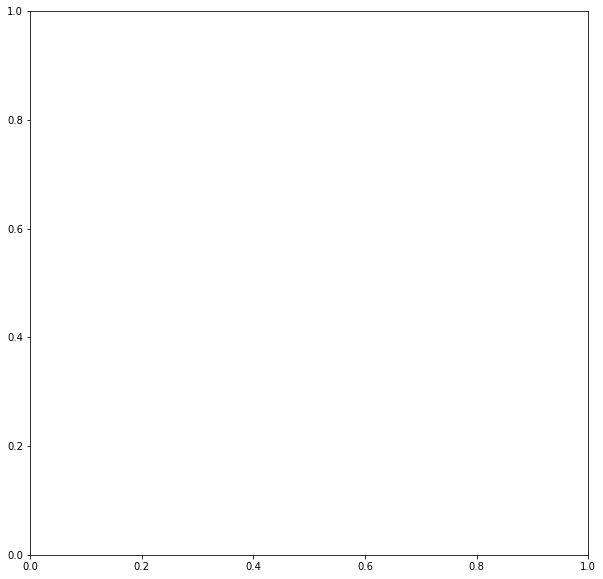

In [45]:
try:
    model_trained = train_model(resnet50, train_data_loader, criterion, optimizer, train_loss, train_acc, total_step, n_epochs)
except Exception:
    print(traceback.format_exc())
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Save Model

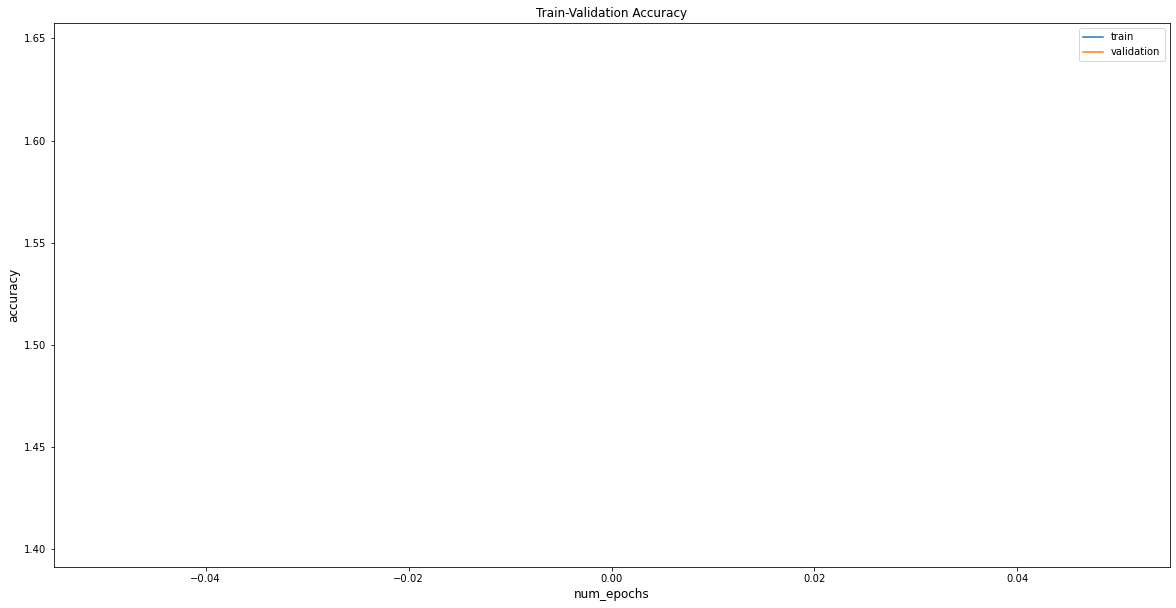

In [44]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
resnet50.load_state_dict(torch.load('models/pytorch/traiend_resnet50.h5'))                 

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias". 



## OVER SAMPLEING ## 


TEST Github+
TRY +1


## Yelei Test